# Example of using max-flow/min-cut algorithm for gender labeling problem

The code provided in connection with the section 5.3 (Graph cuts for optimizing MRF) of the lecture notes.

For solving max-flow/mic-cut we use `maxflow` package, see [https://pmneila.github.io/PyMaxflow/](https://pmneila.github.io/PyMaxflow/).

The example below is set-up exactly as in the lecture notes. You are adwised to experiment by changing the set up. In particular, try increasing the number of data points, for example as use the following for data term.
```
d = np.random.randint(low=145, high=201, size=50, dtype=int)
d += (5*np.sin(np.linspace(0, 4*np.pi, len(d)))).astype(int)

```

Also experiment with changing the value of `beta`. Setting `beta=0` corresponds to max-likelihood solution. Choosing larger `beta` should yield incresingly smooth solution.


In [1]:
import maxflow
import numpy as np
import matplotlib.pyplot as plt

## Setting up the problem

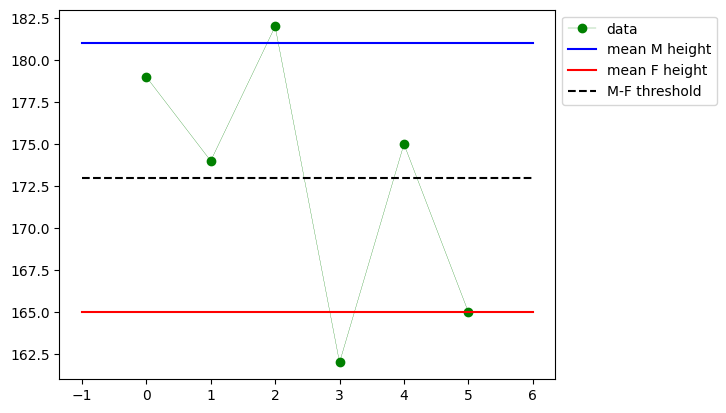

[173.0, 173.0]


In [5]:
d = np.array([179, 174, 182, 162, 175, 165]) # heights (data term)

mu = [181, 165] # means of two classes, used for computation of likelihood
w_s = (d - mu[0]) ** 2 # source weight
w_t = (d - mu[1]) ** 2 # sink weights

fig, ax = plt.subplots()
ax.plot(d, '-og', lw=0.2, label='data')
ax.plot([-1, len(d)], [mu[0]]*2, 'b', label='mean M height')
ax.plot([-1, len(d)], [mu[1]]*2, 'r', label='mean F height')
ax.plot([-1, len(d)], [0.5*(mu[0] + mu[1])]*2, '--k', label='M-F threshold')
ax.legend(bbox_to_anchor = (1, 1))
plt.show()

print([0.5*(mu[0] + mu[1])]*2)

## Solving the assignment problem using graph-cut

Heights of 6 people: [179 174 182 162 175 165]
Mean heights: Male = 181cm, Female = 165cm

Data costs for each person:
Person 1 (height 179cm):
  Cost if male: 4
  Cost if female: 196
Person 2 (height 174cm):
  Cost if male: 49
  Cost if female: 81
Person 3 (height 182cm):
  Cost if male: 1
  Cost if female: 289
Person 4 (height 162cm):
  Cost if male: 361
  Cost if female: 9
Person 5 (height 175cm):
  Cost if male: 36
  Cost if female: 100
Person 6 (height 165cm):
  Cost if male: 256
  Cost if female: 0

Smoothing parameter β = 1000

Created 6 nodes in the graph
Added edge between node 1 and node 2 with capacity 1000
Added edge between node 2 and node 3 with capacity 1000
Added edge between node 3 and node 4 with capacity 1000
Added edge between node 4 and node 5 with capacity 1000
Added edge between node 5 and node 6 with capacity 1000
Node 1: Source capacity = 196, Sink capacity = 4
Node 2: Source capacity = 81, Sink capacity = 49
Node 3: Source capacity = 289, Sink capacity = 1
Nod

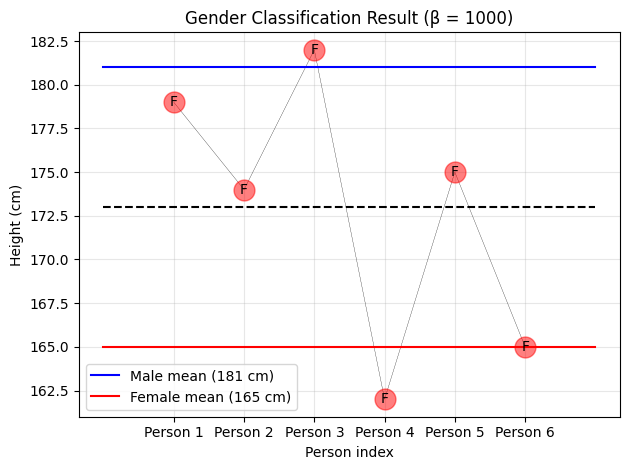


Changing the β value leads to different results:
- β = 0: Each person classified independently based on height
- β = 5-50: Some smoothing effect
- β = 100-1000: Stronger smoothing, adjacent people tend to have same label
- β > 1000: Very strong smoothing, may force all to same label


In [33]:
# Add at the beginning to see the height data
print(f"Heights of 6 people: {d}")
print(f"Mean heights: Male = {mu[0]}cm, Female = {mu[1]}cm")

# Add after calculating w_s and w_t to see the costs
print("\nData costs for each person:")
for i in range(len(d)):
    print(f"Person {i+1} (height {d[i]}cm):")
    print(f"  Cost if male: {(d[i] - mu[0]) ** 2}")
    print(f"  Cost if female: {(d[i] - mu[1]) ** 2}")

# Set the smoothness parameter (penalty for adjacent nodes having different labels)
beta = 1000  # try changing between 0 and 5000
print(f"\nSmoothing parameter β = {beta}")


# Create a graph with integer capacities.
g = maxflow.Graph[int]()

# Add (non-terminal) nodes and retrieve an index for each node.
nodes = g.add_nodes(len(d))

# Add after creating nodes
print(f"\nCreated {len(nodes)} nodes in the graph")

# Create edges between nodes.
for i in range(len(d)-1):
    g.add_edge(nodes[i], nodes[i+1], beta, beta)
    print(f"Added edge between node {i+1} and node {i+2} with capacity {beta}")

# Set the capacities of the terminal edges.
#for i in range(len(d)):
#    g.add_tedge(nodes[i], (d[i] - mu[1]) ** 2, (d[i] - mu[0]) ** 2)
for i in range(len(d)):
    source_cap = (d[i] - mu[1]) ** 2
    sink_cap = (d[i] - mu[0]) ** 2
    g.add_tedge(nodes[i], source_cap, sink_cap)
    print(f"Node {i+1}: Source capacity = {source_cap}, Sink capacity = {sink_cap}")

# Run the max flow algorithm.
flow = g.maxflow()
print(f"\nMax flow value: {flow}")

# Get the result as integer labels.
labeling = [g.get_segment(n) for n in nodes]
gender_labels = ['Male' if l == 0 else 'Female' for l in labeling]
print("\nFinal labeling (0 = Male, 1 = Female):")
for i in range(len(d)):
    print(f"  Person {i+1} (height {d[i]}cm): {labeling[i]} ({gender_labels[i]})")

# Calculate the total energy (cost) of the solution
data_cost = sum(w_s[i] if labeling[i] == 0 else w_t[i] for i in range(len(d)))
smoothness_cost = beta * sum(1 for i in range(len(d)-1) if labeling[i] != labeling[i+1])
total_cost = data_cost + smoothness_cost
print(f"\nTotal energy (cost) of the solution: {total_cost}")
print(f"  Data cost: {data_cost}")
print(f"  Smoothness cost: {smoothness_cost} (β × {smoothness_cost/beta if beta > 0 else 0} label changes)")


# Visualize
fig, ax = plt.subplots()
ax.plot([-1, len(d)], [0.5*(mu[0] + mu[1])]*2, '--k')
ax.plot(d, '-k', lw=0.2)
for i, di in enumerate(d):
    color = 'b' if labeling[i] == 0 else 'r'
    letter = 'M' if labeling[i] == 0 else 'F'
    ax.plot(i, di, 'o', color=color, alpha=0.5, markersize=15)
    ax.text(i, di, letter, ha='center', va='center')
# Add horizontal lines for the means
ax.plot([-1, len(d)], [mu[0]]*2, 'b', label='Male mean (181 cm)')
ax.plot([-1, len(d)], [mu[1]]*2, 'r', label='Female mean (165 cm)')

ax.set_title(f'Gender Classification Result (β = {beta})')
ax.set_xlabel('Person index')
ax.set_ylabel('Height (cm)')
ax.set_xticks(range(len(d)))
ax.set_xticklabels([f'Person {i+1}' for i in range(len(d))])
ax.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



# You can experiment by changing β and see how the results change
print("\nChanging the β value leads to different results:")
print("- β = 0: Each person classified independently based on height")
print("- β = 5-50: Some smoothing effect")
print("- β = 100-1000: Stronger smoothing, adjacent people tend to have same label")
print("- β > 1000: Very strong smoothing, may force all to same label")